In [2]:
%pylab inline

import sys
sys.path.append('code/')
from doublet_detector import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.rc('font', size=14)

### Read in raw counts (rows=cells, columns=genes)

In [ ]:

E = scipy.io.mmread('/home/jovyan/jamboree/doublet-datasets/dataset1/Ye2_sparse_molecule_counts.mtx').toarray()

print E.shape

### Calculate scores - training set

In [3]:
# load cell barcode names for the full data set
all_bcs = list(np.loadtxt('/home/jovyan/jamboree/doublet-datasets/dataset1/Ye2_barcode_id.csv', 
                          delimiter=',', dtype=str)[:,1])

# load cell barcode names and singlet/doublet labels for the training set
dat = np.loadtxt('/home/jovyan/jamboree/doublet-datasets/dataset1/Ye2_L001_001_train_labels.txt', dtype=str)
train_bcs = dat[:,0]
train_doub_labels = dat[:,1]

# match full BC list to training BC list
train_cell_ix = np.array([all_bcs.index(x) for x in train_bcs])

print len(train_cell_ix)


11086


In [4]:
# Predictor 1: total UMIs per cell
# UMIs/cell is a simple predictor for doublets, but fairly effective for this data set

tot_counts = np.sum(E[train_cell_ix, :], axis=1)

In [5]:
# Predictor 2: Similarity to simulated doublets
# This predictor is good at picking out doublets that are combinations of two transcriptionally distinct cells

doub_score_obs, doub_score_full, doub_labels_sim = detect_doublets(E[train_cell_ix, :], doub_frac=5, k=75, num_pc=30, 
                                                              min_counts=3, min_cells=3, vscore_percentile=80)




Total count normalizing
Finding highly variable genes
('Using', 984, 'genes for PCA')
Simulating doublets
('Running KNN classifier with k =', 450)
Done


In [16]:
# Save predictors to a CSV file
outdat = np.zeros(len(tot_counts), dtype='S16,float,int,S16')
outdat['f0'] = train_bcs
outdat['f1'] = doub_score_obs
outdat['f2'] = tot_counts
outdat['f3'] = train_doub_labels

np.savetxt('output/doub_predictors.train.csv', outdat, 
           header = 'bc,doub_score,tot_counts,known_cell_label', 
           fmt = '%s,%.4f,%i,%s',
           comments='')

### Calculate scores - test set

In [17]:
# load cell barcode names for the test data set
test_bcs = np.loadtxt('/home/jovyan/jamboree/doublet-datasets/dataset1/Ye2_L001_001_test_labels_predict_me.txt', 
                      dtype=str)
test_cell_ix = np.array([all_bcs.index(x) for x in test_bcs])

print len(test_cell_ix)

In [18]:
# Predictor 1: total UMIs per cell

tot_counts = np.sum(E[test_cell_ix, :], axis=1)

In [19]:
# Predictor 2: Similarity to simulated doublets

doub_score_obs, doub_score_full, doub_labels_sim = detect_doublets(E[test_cell_ix, :], doub_frac=5, k=75, num_pc=30, 
                                                              min_counts=3, min_cells=3, vscore_percentile=80)


Total count normalizing
Finding highly variable genes
('Using', 1041, 'genes for PCA')
Simulating doublets
('Running KNN classifier with k =', 450)
Done


In [20]:
# Save predictors to a CSV file

outdat = np.zeros(len(tot_counts), dtype='S16,float,int')
outdat['f0'] = test_bcs
outdat['f1'] = doub_score_obs
outdat['f2'] = tot_counts

np.savetxt('output/doub_predictors.test.csv', outdat, 
           header = 'bc,doub_score,tot_counts', 
           fmt = '%s,%.4f,%i',
           comments='')

# Check out the results

In [3]:
# load previously generated predictors (see above)

train_dat = np.loadtxt('output/doub_predictors.train.csv', dtype='S16,float,int,S16', delimiter=',',skiprows=1)
test_dat = np.loadtxt('output/doub_predictors.test.csv', dtype='S16,float,int', delimiter=',',skiprows=1)

doub_score_train = train_dat['f1']
tot_counts_train = train_dat['f2']
train_doub_labels = train_dat['f3']

test_bcs = test_dat['f0']
doub_score_test = test_dat['f1']
tot_counts_test = test_dat['f2']


### Training data

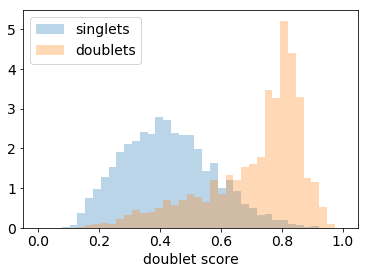

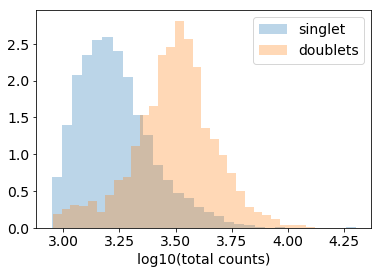

In [8]:
fig, ax = plt.subplots(1,1)
ax.hist(doub_score_train[train_doub_labels=='singlet'], normed=True, bins=np.linspace(0, 1, 40), 
        alpha = 0.3, label='singlets');
ax.hist(doub_score_train[train_doub_labels=='doublet'], normed=True, bins=np.linspace(0, 1, 40), 
        alpha = 0.3, label='doublets');
ax.set_xlabel('doublet score')
ax.legend()


fig, ax = plt.subplots(1,1)
ax.hist(np.log10(tot_counts_train[(train_doub_labels=='singlet')]), normed=True, bins=30, 
        alpha = 0.3, label='singlet');
ax.hist(np.log10(tot_counts_train[(train_doub_labels=='doublet')]), normed=True, bins=30, 
        alpha = 0.3, label='doublets');
ax.set_xlabel('log10(total counts)')
ax.legend()


### Test data

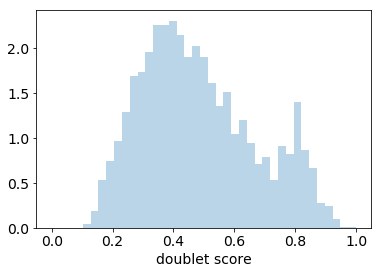

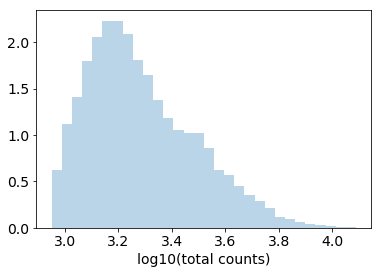

In [9]:

fig, ax = plt.subplots(1,1)
ax.hist(doub_score_test, normed=True, bins=np.linspace(0, 1, 40), alpha = 0.3);
ax.set_xlabel('doublet score')


fig, ax = plt.subplots(1,1)
ax.hist(np.log10(tot_counts_test), normed=True, bins=30, alpha = 0.3);
ax.set_xlabel('log10(total counts)')


# Integrate the two predictors using a GLM

### Fit model using the training data

In [10]:
glm = sklearn.linear_model.LogisticRegression(penalty='l1', max_iter = 1000)
glm.fit(np.hstack((doub_score_train[:, None], np.log10(tot_counts_train)[:,None])),
        train_doub_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Apply the model

AUC = 0.9151
Set threshold for FPR = 0.08 (TPR = 0.81)
Predicted doublet rates:
	 Training set: 21% 
	 Test set: 22%


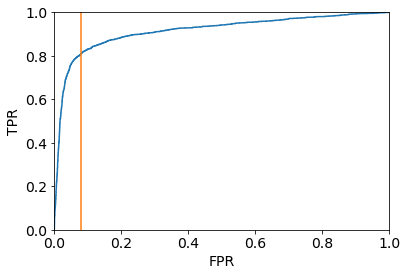

In [11]:
desired_fpr = 0.08

#####
prob_train = glm.predict_proba(np.hstack((doub_score_train[:, None], np.log10(tot_counts_train)[:,None])))[:,0]

print 'AUC = %.4f' %(sklearn.metrics.roc_auc_score(train_doub_labels == 'doublet', prob_train))


fpr, tpr, thr = sklearn.metrics.roc_curve(train_doub_labels == 'doublet', prob_train)
fpr_ix = np.argmin(abs(fpr - desired_fpr))

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.plot([desired_fpr, desired_fpr], ax.get_ylim())



resulting_tpr = tpr[fpr_ix]
min_prob = thr[fpr_ix]

print 'Set threshold for FPR = %.2f (TPR = %.2f)' %(desired_fpr, resulting_tpr)

prob_test = glm.predict_proba(np.hstack((doub_score_test[:, None], np.log10(tot_counts_test)[:,None])))[:,0]

print 'Predicted doublet rates:\n\t Training set: %i%s \n\t Test set: %i%s' %( 
                100 * np.sum(prob_train > min_prob) / float(len(prob_train)), "%",
                100 * np.sum(prob_test > min_prob) / float(len(prob_test)), "%")


final_calls = np.array(['doublet' if p > min_prob else 'singlet' for p in prob_test ])

In [20]:
# Save final predictions

outdat = np.zeros(len(test_bcs), dtype='S16,S16,float')
outdat['f0'] = test_bcs
outdat['f1'] = final_calls
outdat['f2'] = prob_test

np.savetxt('output/test_data_predictions.txt', outdat, 
           fmt = '%s\t%s\t%.6f',
           comments='')

In [13]:
print 'AUC (total counts only): %.4f' %(sklearn.metrics.roc_auc_score(train_doub_labels == 'doublet', tot_counts_train))
print 'AUC (simulation approach only): %.4f' %(sklearn.metrics.roc_auc_score(train_doub_labels == 'doublet', doub_score_train))
print 'AUC (combined): %.4f' %(sklearn.metrics.roc_auc_score(train_doub_labels == 'doublet', prob_train))

AUC (total counts only): 0.8535
AUC (simulation approach only): 0.8924
AUC (combined): 0.9151
